# Test tiger with location scale regression

In [2]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

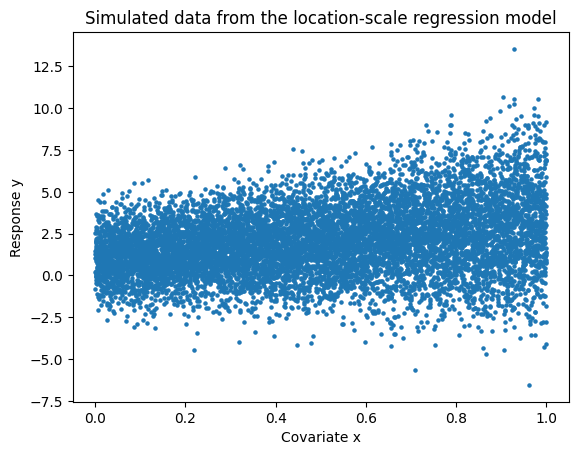

In [3]:
# sample size and true parameters

n = 10000
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([0.25, 0.75])

# data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# plot the simulated data

plt.scatter(x0, response_vec, s = 5)
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [4]:
# set up design matrix location
X = tiger.Obs(name = "X_loc")
X.fixed(data = x0)

# set up design matrix scale
Z = tiger.Obs(name = "Z_scale")
Z.fixed(data = x0)

# set up hyperparameters
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# set up hyperparameters
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(3.0, name="gamma_scale")

# set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, beta=beta)
lpred_scale = tiger.Lpred(obs=Z, gamma=gamma, function=jnp.exp)

# set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [5]:
jnp.sum(m.log_lik)

Array(-50508.688, dtype=float32)

In [6]:
m.log_prior

Array([-11.048218,  -4.035102], dtype=float32)

In [7]:
m.log_prob

Array(-50523.77, dtype=float32)

In [8]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

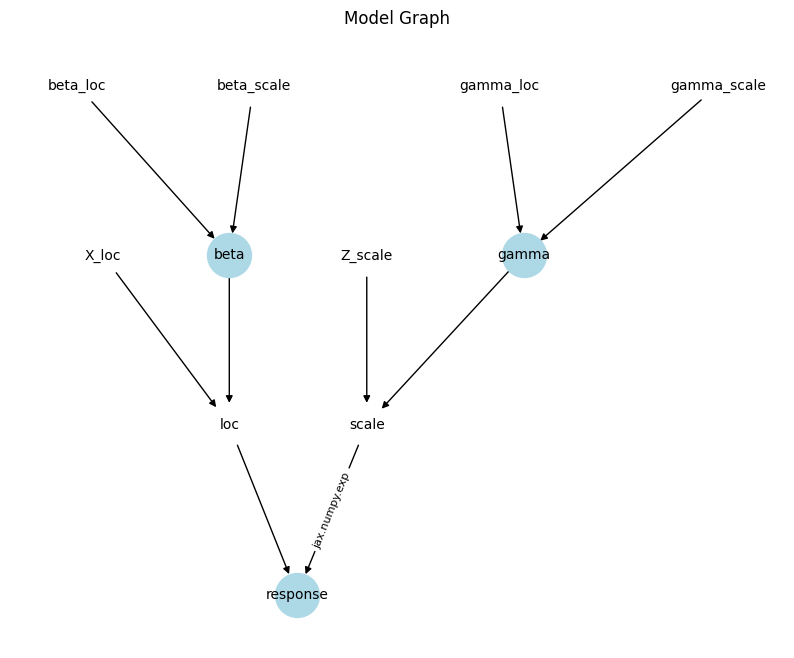

In [9]:
graph.visualize_graph()

## Inference with BBVI

In [10]:
q = bbvi.Bbvi(graph=graph)

In [11]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

In [17]:
q.run_bbvi(step_size=0.1,
           threshold=1e-2,
           key=27,
           batch_size=128,
           num_var_samples=32,
           chunk_size=50,
           epochs=1000)

2023-09-26 17:14:27.463586: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_jscan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-09-26 17:28:34.900423: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m7.446569s

********************************
[Compiling module jit_jscan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


(Array(-20754.602, dtype=float32),
 {'beta': {'loc': Array([0.94527215, 2.0571365 ], dtype=float32),
   'cov': Array([[ 0.00082489, -0.00156697],
          [-0.00156697,  0.00456591]], dtype=float32)},
  'gamma': {'loc': Array([0.16783303, 0.83478516], dtype=float32),
   'cov': Array([[ 0.00019946, -0.00029217],
          [-0.00029217,  0.00058376]], dtype=float32)}})

In [10]:
with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    q.run_bbvi(step_size=0.1,
           threshold=1e-2,
           key=27,
           batch_size=128,
           num_var_samples=64,
           chunk_size=50,
           epochs=1000)

Open URL in browser: https://ui.perfetto.dev/#!/?url=http://127.0.0.1:9001/perfetto_trace.json.gz


127.0.0.1 - - [26/Sep/2023 14:11:32] code 404, message File not found
127.0.0.1 - - [26/Sep/2023 14:11:32] "POST /status HTTP/1.1" 404 -
127.0.0.1 - - [26/Sep/2023 14:11:32] "GET /perfetto_trace.json.gz HTTP/1.1" 200 -


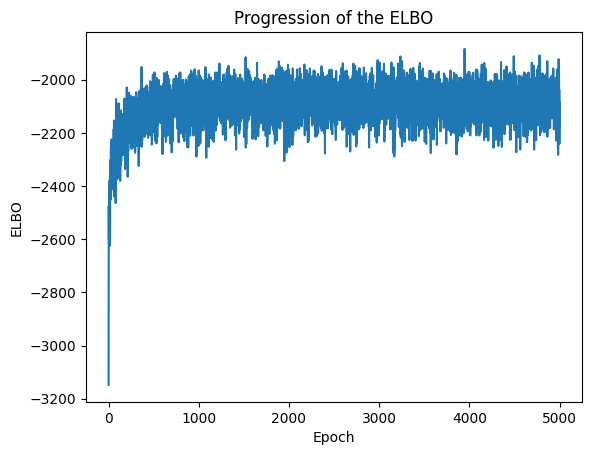

In [11]:
q.plot_elbo()